In [9]:
!pip install opendatasets

import opendatasets as od
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


od.download('https://www.kaggle.com/datasets/simulhasantalukder/jutepestindentification')



Skipping, found downloaded files in "./jutepestindentification" (use force=True to force download)


In [23]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

TRAIN_DATA_DIR='/content/jutepestindentification/Jute'
TESTING_DATA_DIR='/content/jutepestindentification/Jute'

train_data = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    subset='training',
    validation_split=0.1,
    seed=42
)


validation_data = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    subset='validation',
    validation_split=0.1,
    seed=42
)

classes=train_data.class_names

Found 6209 files belonging to 17 classes.
Using 5589 files for training.
Found 6209 files belonging to 17 classes.
Using 620 files for validation.


In [24]:
classes

['Black hairy',
 'Cutworm',
 'Field Cricket',
 'Indigo caterpillar',
 'Jute Stem Weevil',
 'Jute aphid',
 'Jute hairy',
 'Jute red mite',
 'Jute semilooper',
 'Jute stem girdler',
 'Jute stick insect',
 'Leaf beetle',
 'Mealybug',
 'Pod borer',
 'Termite',
 'Termite odontotermes (Rambur)',
 'Yellow Mite']

In [11]:
train_data = train_data.map(lambda x,y:(x/255,y))
validation_data = validation_data.map(lambda x,y:(x/255,y))

In [13]:
pretrained_model = tf.keras.applications.Xception(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet",
    pooling='max'
)
for layer in pretrained_model.layers:
    layer.trainable = False

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

In [15]:
model = tf.keras.Sequential([

    data_augmentation,
    pretrained_model,
    tf.keras.layers.Flatten(),

    # Add Dense layers
    tf.keras.layers.Dense(units=256, activation='relu'),

    tf.keras.layers.Dense(units=128, activation='relu'),

    tf.keras.layers.Dense(units=128, activation='relu'),

    tf.keras.layers.Dense(units=128, activation='relu'),

    tf.keras.layers.Dense(units=128, activation='relu'),

    tf.keras.layers.Dense(units=128, activation='relu'),


    # Output layer
    tf.keras.layers.Dense(units=17, activation='softmax')
])

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Using SparseCategoricalCrossentropy for integer labels
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_data,
    epochs=5,
    validation_data=validation_data
)

Epoch 1/5
175/175 [==============================] - 38s 169ms/step - loss: 1.3193 - accuracy: 0.5700 - val_loss: 0.7971 - val_accuracy: 0.7323
Epoch 2/5
175/175 [==============================] - 29s 167ms/step - loss: 0.6877 - accuracy: 0.7729 - val_loss: 0.4136 - val_accuracy: 0.8645
Epoch 3/5
175/175 [==============================] - 27s 150ms/step - loss: 0.4706 - accuracy: 0.8493 - val_loss: 0.3693 - val_accuracy: 0.8871
Epoch 4/5
175/175 [==============================] - 27s 150ms/step - loss: 0.4222 - accuracy: 0.8674 - val_loss: 0.2894 - val_accuracy: 0.9113
Epoch 5/5
175/175 [==============================] - 27s 152ms/step - loss: 0.3564 - accuracy: 0.8844 - val_loss: 0.2118 - val_accuracy: 0.9355


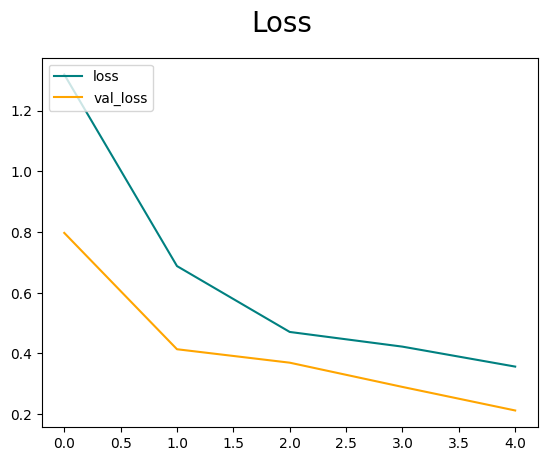

In [17]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

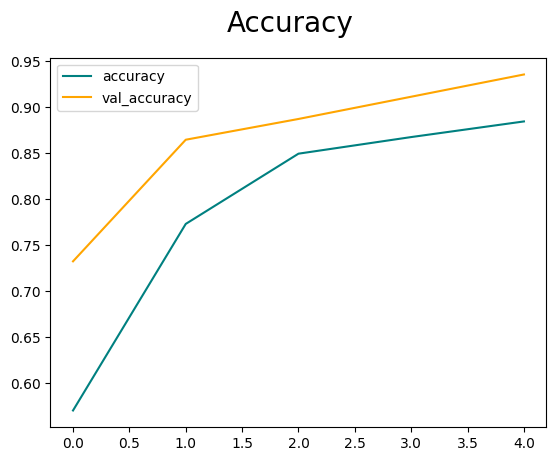

In [18]:

fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [19]:
model.save('17_pest_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
